<a href="https://colab.research.google.com/github/isosafrasaurus/3D-1D/blob/main/3D1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
WD_PATH = "/content/drive/MyDrive/Research/3D-1D/"
VENV_PATH = WD_PATH + "/.venv"

In [ ]:
# @title Install and import required libraries
!pip3 install virtualenv

import os, re
if not os.path.exists(VENV_PATH):
  !virtualenv $VENV_PATH

import sys
sys.path.append(VENV_PATH + "/lib/python3.10/site-packages")

def replace_in_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()

    # Replace 'ufl' with 'ufl_legacy'
    content = re.sub(r'\bufl\b', 'ufl_legacy', content)

    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(content)

def process_directory(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.py'):
                file_path = os.path.join(root, file)
                replace_in_file(file_path)

# dolfin
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

# block
try:
    import block
except ImportError:
    !git clone https://bitbucket.org/fenics-apps/cbc.block/src/master/
    !source $VENV_PATH/bin/activate && python3 -m pip install master/

# fenics_ii
try:
    import xii
except ImportError:
    !git clone https://github.com/MiroK/fenics_ii
    process_directory("fenics_ii/")
    !source $VENV_PATH/bin/activate && python3 -m pip install fenics_ii/

# vtk
try:
    import vtk
except ImportError:
    !source $VENV_PATH/bin/activate && pip install vtk

# graphnics
try:
    import graphnics
except ImportError:
    !git clone https://github.com/IngeborgGjerde/graphnics
    !source $VENV_PATH/bin/activate && python3 -m pip install graphnics/

In [27]:
# @title pv_1.py modified
import json
from dolfin import *
from xii import *
import numpy as np
from graphnics import *
import matplotlib.pyplot as plt

G = FenicsGraph()
ind = 0
branch_points = {}

for n in range(29):
    file_name = WD_PATH+'/data/pv_json1_mod/Centerline_'+str(n)+'.mrk.json'
    f = open(file_name)
    data = json.load(f)
    f.close()

    # get coords + radius at each point
    points = data['markups'][0]['controlPoints']
    radius = data['markups'][0]['measurements'][3]['controlPointValues']
    G.add_nodes_from(range(ind - n, ind + len(points) - n))

    # check if first coord is branch point from previous centerlines
    v1 = 0
    for key, val in branch_points.items():
        if points[0]['position'] == val:
            v1 = key
            break

    # add coords and radius to nodes fenics graph
    v2 = ind - n + 1
    pos_v1 = points[0]['position']
    pos_v2 = points[1]['position']
    G.nodes[v1]["pos"] = pos_v1
    G.nodes[v2]["pos"] = pos_v2
    G.nodes[v1]["radius"] = radius[0]
    G.nodes[v2]["radius"] = radius[1]
    # add edge to fenics graph
    G.add_edge(v1, v2)

    for i in range(len(points)-2):
        v1 = ind - n + 1 + i
        v2 = v1 + 1
        pos_v1 = points[i + 1]['position']
        pos_v2 = points[i + 2]['position']
        G.nodes[v1]["pos"] = pos_v1
        G.nodes[v2]["pos"] = pos_v2
        G.nodes[v1]["radius"] = radius[i + 1]
        G.nodes[v2]["radius"] = radius[i + 2]
        G.add_edge(v1, v2)

    # store last point as a branch point
    ind += len(points)
    branch_points.update({ind-n-1: pos_v2})

# create 1d mesh
G.make_mesh()
mesh1d = G.mesh

# get positions of 1d mesh
pos = nx.get_node_attributes(G, "pos")
radii = nx.get_node_attributes(G, "radius")
node_coords = np.asarray(list(pos.values()))
xmin, ymin, zmin = np.min(node_coords, axis = 0)

# recenter 1d coordinates to all be >= 0
d = mesh1d.coordinates()
d[:, :] += [-xmin, -ymin, -zmin]

# create 3d mesh
mesh3d = UnitCubeMesh(16, 16, 32)

# fit 3d mesh around 1d mesh
c = mesh3d.coordinates()
xl, yl, zl = (np.max(node_coords, axis=0)-np.min(node_coords, axis=0)) # graph length scales

c[:,:] *= [xl+3, yl+3, zl] #rescale lengths

# set constants for simulation
Alpha1 = Constant(9.6e-2)
alpha1 = Constant(1.45e4)
beta = Constant(3.09e-5)

# set boundary conditions for simulation
bc_3d = Constant(3)
bc_1d = Expression("0.02*x[2]+6", degree=0)

# define function that returns lateral faces of 3d boundary
def boundary_3d(x, on_boundary):
    return on_boundary and not near(x[2], 0) and not near(x[2], zl)

# Pressure space on global mesh
V3 = FunctionSpace(mesh3d, "CG", 1)
V1 = FunctionSpace(mesh1d, "CG", 1)
W = [V3, V1]

u3, u1 = list(map(TrialFunction, W))
v3, v1 = list(map(TestFunction, W))

# Create a radius function for the averaging surface
class RadiusFunction(UserExpression):
    def __init__(self, radii_map, pos_map, **kwargs):
        self.radii_map = radii_map
        self.pos_map = pos_map
        super().__init__(**kwargs)

    def eval(self, value, x):
        min_dist = float('inf')
        closest_radius = 0
        for node, position in self.pos_map.items():
            pos = np.array(position)
            dist = np.linalg.norm(x - pos)
            if dist < min_dist:
                min_dist = dist
                closest_radius = self.radii_map[node]
        value[0] = closest_radius

    def value_shape(self):
        return ()

radius_function = RadiusFunction(radii, pos, degree=2)
cylinder = Circle(radius=radius_function, degree=10)

Pi_u = Average(u3, mesh1d, cylinder)
Pi_v = Average(v3, mesh1d, cylinder)

# Dirac measure
dxGamma = Measure("dx", domain=mesh1d)

# blocks
a00 = Alpha1 * inner(grad(u3), grad(v3)) * dx + beta * inner(Pi_u, Pi_v) * dxGamma
a01 = -beta * inner(u1, Pi_v) * dxGamma
a10 = -beta * inner(Pi_u, v1) * dxGamma
a11 = alpha1 * inner(grad(u1), grad(v1)) * dx + beta * inner(u1, v1) * dxGamma

# right-hand side
L0 = inner(Constant(0), Pi_v) * dxGamma
L1 = inner(Constant(0), v1) * dxGamma

a = [[a00, a01], [a10, a11]]
L = [L0, L1]

W_bcs = [[DirichletBC(V3, bc_3d, boundary_3d)], [DirichletBC(V1, bc_1d, "on_boundary")]]

A, b = map(ii_assemble, (a, L))
A, b = apply_bc(A, b, W_bcs)
A, b = map(ii_convert, (A, b))

wh = ii_Function(W)
solver = LUSolver(A, "mumps")
solver.solve(wh.vector(), b)

uh3d, uh1d = wh
# File(WD_PATH + 'plots/pv1_mod/pressure1d.pvd') << uh1d
# File(WD_PATH + 'plots/pv1_mod/pressure3d.pvd') << uh3d

Averaging over 792 cells: 100%|██████████| 792/792 [00:04<00:00, 182.27it/s]


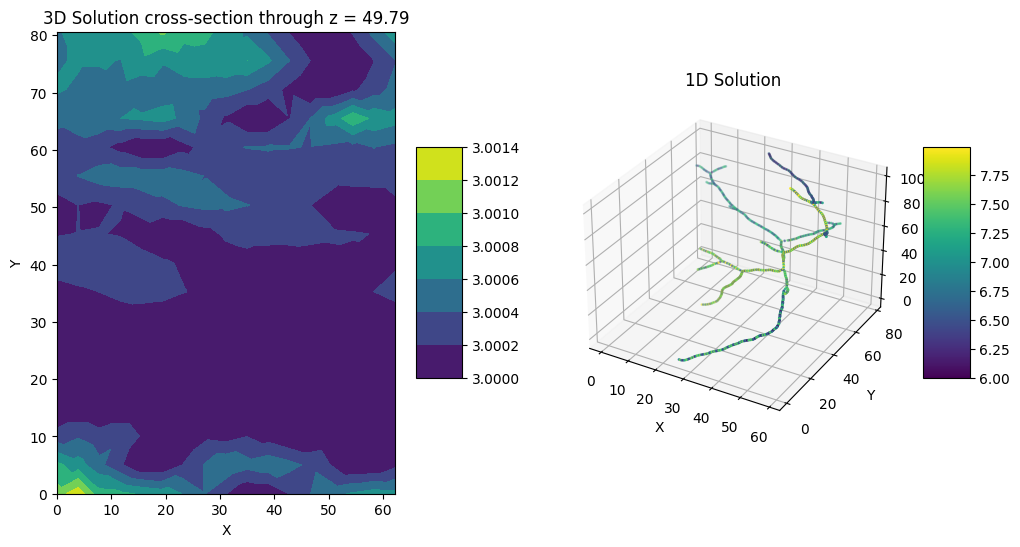

In [34]:
#@title visualizer
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from dolfin import *

# Extract solution arrays
u3d_vals = uh3d.vector().get_local()
u1d_vals = uh1d.vector().get_local()

# Extract coordinates
coords3d = mesh3d.coordinates()
coords1d = mesh1d.coordinates()

# Extract x, y, z values for 3D
x3d_vals = coords3d[:, 0]
y3d_vals = coords3d[:, 1]
z3d_vals = coords3d[:, 2]

# Extract x, y, z values for 1D
x1d_vals = coords1d[:, 0]
y1d_vals = coords1d[:, 1]
z1d_vals = coords1d[:, 2]

# Choose a z-slice (e.g., z=0.5 * max(z))
z_slice = 0.5 * np.max(coords3d[:, 2])

# Find indices of points in the z-slice
slice_indices = np.where(np.abs(coords3d[:, 2] - z_slice) < 1e-3)[0]

# Extract coordinates and solution values for the slice
x_slice = coords3d[slice_indices, 0]
y_slice = coords3d[slice_indices, 1]
u_slice = u3d_vals[slice_indices]

# Plotting 3D data and heatmap
fig = plt.figure(figsize=(12, 6))

# Heatmap for a slice of uh3d
ax1 = fig.add_subplot(121)
triang = mpl.tri.Triangulation(x_slice, y_slice)
contour = ax1.tricontourf(triang, u_slice, cmap='viridis')
fig.colorbar(contour, ax=ax1, shrink=0.5, aspect=5)
ax1.set_title(f'3D Solution cross-section through z = {z_slice:.2f}')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')

# 3D scatter plot for uh1d
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(x1d_vals, y1d_vals, z1d_vals, c=u1d_vals, cmap='viridis', s=1)
ax2.set_title("1D Solution")
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.set_zlabel("Z")
fig.colorbar(scatter2, ax=ax2, shrink=0.5, aspect=5)

plt.show()

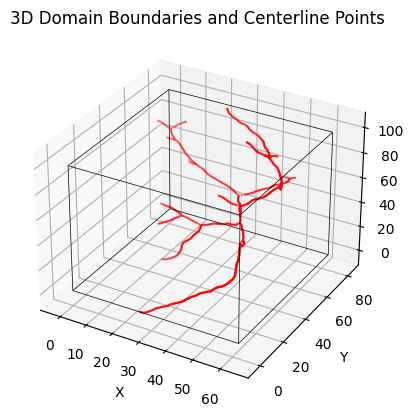

In [33]:
import matplotlib.pyplot as plt
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import collections as mc

# Extract transformed coordinates from 3D mesh
c = mesh3d.coordinates()
xmin, ymin, zmin = np.min(c, axis=0)
xmax, ymax, zmax = np.max(c, axis=0)

# Recenter 1D coordinates to all be >= 0
d = mesh1d.coordinates()
d[:, :] += [-xmin, -ymin, -zmin]

# Extract positions from the recentered 1D mesh
node_coords_transformed = d

# Create a figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the boundaries of the 3D domain box
edges = [
    [(xmin, ymin, zmin), (xmax, ymin, zmin)],
    [(xmax, ymin, zmin), (xmax, ymax, zmin)],
    [(xmax, ymax, zmin), (xmin, ymax, zmin)],
    [(xmin, ymax, zmin), (xmin, ymin, zmin)],
    [(xmin, ymin, zmax), (xmax, ymin, zmax)],
    [(xmax, ymin, zmax), (xmax, ymax, zmax)],
    [(xmax, ymax, zmax), (xmin, ymax, zmax)],
    [(xmin, ymax, zmax), (xmin, ymin, zmax)],
    [(xmin, ymin, zmin), (xmin, ymin, zmax)],
    [(xmax, ymin, zmin), (xmax, ymin, zmax)],
    [(xmax, ymax, zmin), (xmax, ymax, zmax)],
    [(xmin, ymax, zmin), (xmin, ymax, zmax)]
]

line_collection = mpl_toolkits.mplot3d.art3d.Line3DCollection(edges, colors='k', linewidths=0.5)
ax.add_collection3d(line_collection)

# Plot the transformed positions of the points on the centerlines in the 3D domain
ax.scatter(node_coords_transformed[:, 0], node_coords_transformed[:, 1], node_coords_transformed[:, 2], c='r', marker='o', s=0.5)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Domain Boundaries and Centerline Points')

# Adjust the limits to zoom out a bit
ax.set_xlim([xmin - 0.1 * (xmax - xmin), xmax + 0.1 * (xmax - xmin)])
ax.set_ylim([ymin - 0.1 * (ymax - ymin), ymax + 0.1 * (ymax - ymin)])
ax.set_zlim([zmin - 0.1 * (zmax - zmin), zmax + 0.1 * (zmax - zmin)])

plt.show()


In [ ]:
# @title pv_1 modified old
import json
from dolfin import *
from xii import *
import numpy as np
from graphnics import *

G = FenicsGraph()
ind = 0
branch_points = {}

for n in range(1):
    file_name = WD_PATH+'/data/pv_json1_mod/Centerline_'+str(n)+'.mrk.json'
    f = open(file_name)
    data = json.load(f)
    f.close()

    # get coords + radius at each point
    points = data['markups'][0]['controlPoints']
    radius = data['markups'][0]['measurements'][3]['controlPointValues']
    G.add_nodes_from(range(ind - n, ind + len(points) - n))

    # check if first coord is branch point from previous centerlines
    v1 = 0
    for key, val in branch_points.items():
        if points[0]['position'] == val:
            v1 = key
            break

    # add coords and radius to nodes fenics graph
    v2 = ind - n + 1
    pos_v1 = points[0]['position']
    pos_v2 = points[1]['position']
    G.nodes[v1]["pos"] = pos_v1
    G.nodes[v2]["pos"] = pos_v2
    G.nodes[v1]["radius"] = radius[0]
    G.nodes[v2]["radius"] = radius[1]
    # add edge to fenics graph
    G.add_edge(v1, v2)

    for i in range(len(points)-2):
        v1 = ind - n + 1 + i
        v2 = v1 + 1
        pos_v1 = points[i + 1]['position']
        pos_v2 = points[i + 2]['position']
        G.nodes[v1]["pos"] = pos_v1
        G.nodes[v2]["pos"] = pos_v2
        G.nodes[v1]["radius"] = radius[i + 1]
        G.nodes[v2]["radius"] = radius[i + 2]
        G.add_edge(v1, v2)


    # store last point as a branch point
    ind += len(points)
    branch_points.update({ind-n-1: pos_v2})


# create 1d mesh
G.make_mesh()
mesh1d = G.mesh

# get positions of 1d mesh
pos = nx.get_node_attributes(G, "pos")
node_coords = np.asarray(list(pos.values()))
xmin, ymin, zmin = np.min(node_coords, axis = 0)

# recenter 1d coordinates to all be >= 0
d = mesh1d.coordinates()
d[:, :] += [-xmin, -ymin, -zmin]

# create 3d mesh
mesh3d = UnitCubeMesh(16, 16, 32)

# fit 3d mesh around 1d mesh
c = mesh3d.coordinates()
xl, yl, zl = (np.max(node_coords, axis=0)-np.min(node_coords, axis=0)) # graph length scales
c[:,:] *= [xl+3, yl+3, zl] #rescale lengths

# set constants for simulation
Alpha1 = Constant(9.6e-2)
alpha1 = Constant(1.45e4)
beta = Constant(3.09e-5)

# set boundary conditions for simulation
bc_3d = Constant(3)
bc_1d = Expression("0.02*x[2]+6", degree=0)

# define function that returns lateral faces of 3d boundary
def boundary_3d(x, on_boundary):
    return on_boundary and not near(x[2], 0) and not near(x[2], zl)

from scipy.interpolate import interp1d
import numpy as np

# Assuming pos and radius arrays are created from JSON data
# pos = np.array([G.nodes[v]['pos'] for v in G.nodes])
radii = np.array([G.nodes[v]['radius'] for v in G.nodes])

# Interpolate radius function
def resample_array(x, num_points):
    x_new = np.linspace(np.min(x), np.max(x), num=num_points)
    f = interp1d(np.arange(len(x)), x, kind='linear')
    return f(np.linspace(0, len(x) - 1, num=num_points))

def radius_function(x):
    # Determine which array to resample
    if len(c[:, 2]) != len(radii):
        if len(c[:, 2]) > len(radii):
            new_radii = resample_array(radii, len(c[:, 2]))
            x_values = c[:, 2]
        else:
            x_values = resample_array(c[:, 2], len(radii))
            new_radii = radii
    else:
        x_values = c[:, 2]
        new_radii = radii

    interp_func = interp1d(x_values, new_radii, kind='linear', fill_value='extrapolate')

    # Use x[2] as the input to the interpolation function
    return interp_func(x[2])

# Averaging cylinder is defined by mapping points on the centerline to radii
cylinder = Circle(radius=radius_function, degree=10)

# Pressure space on global mesh
V3 = FunctionSpace(mesh3d, "CG", 1)
V1 = FunctionSpace(mesh1d, "CG", 1)
W = [V3, V1]

u3, u1 = list(map(TrialFunction, W))
v3, v1 = list(map(TestFunction, W))

# Define varying radius cylinder for averaging
Pi_u = Average(u3, mesh1d, cylinder)
Pi_v = Average(v3, mesh1d, cylinder)

# Define measures
dxGamma = Measure("dx", domain=mesh1d)

# Define bilinear and linear forms
a00 = Alpha1 * inner(grad(u3), grad(v3)) * dx + beta * inner(Pi_u, Pi_v) * dxGamma
a01 = -beta * inner(u1, Pi_v) * dxGamma
a10 = -beta * inner(Pi_u, v1) * dxGamma
a11 = alpha1 * inner(grad(u1), grad(v1)) * dx + beta * inner(u1, v1) * dxGamma

L0 = inner(Constant(0), Pi_v) * dxGamma
L1 = inner(Constant(0), v1) * dxGamma

a = [[a00, a01], [a10, a11]]
L = [L0, L1]

W_bcs = [[DirichletBC(V3, bc_3d, boundary_3d)], [DirichletBC(V1, bc_1d, "on_boundary")]]

A, b = map(ii_assemble, (a, L))
A, b = apply_bc(A, b, W_bcs)
A, b = map(ii_convert, (A, b))

wh = ii_Function(W)
solver = LUSolver(A, "mumps")
solver.solve(wh.vector(), b)

uh3d, uh1d = wh
File(WD_PATH + 'plots/pv1mod/pressure1d.pvd') << uh1d
File(WD_PATH + 'plots/pv1mod/pressure3d.pvd') << uh3d

In [ ]:
# @title pv_1.py
import json
from dolfin import *
from xii import *
import numpy as np
from graphnics import *
import matplotlib as plt

G = FenicsGraph()
ind = 0
branch_points = {}

for n in range(1):
    file_name = WD_PATH+'/data/pv_json1/Centerline_'+str(n)+'.mrk.json'
    f = open(file_name)
    data = json.load(f)
    f.close()

    # get coords + radius at each point
    points = data['markups'][0]['controlPoints']
    radius = data['markups'][0]['measurements'][3]['controlPointValues']
    G.add_nodes_from(range(ind - n, ind + len(points) - n))

    # check if first coord is branch point from previous centerlines
    v1 = 0
    for key, val in branch_points.items():
        if points[0]['position'] == val:
            v1 = key
            break

    # add coords and radius to nodes fenics graph
    v2 = ind - n + 1
    pos_v1 = points[0]['position']
    pos_v2 = points[1]['position']
    G.nodes[v1]["pos"] = pos_v1
    G.nodes[v2]["pos"] = pos_v2
    G.nodes[v1]["radius"] = radius[0]
    G.nodes[v2]["radius"] = radius[1]
    # add edge to fenics graph
    G.add_edge(v1, v2)

    for i in range(len(points)-2):
        v1 = ind - n + 1 + i
        v2 = v1 + 1
        pos_v1 = points[i + 1]['position']
        pos_v2 = points[i + 2]['position']
        G.nodes[v1]["pos"] = pos_v1
        G.nodes[v2]["pos"] = pos_v2
        G.nodes[v1]["radius"] = radius[i + 1]
        G.nodes[v2]["radius"] = radius[i + 2]
        G.add_edge(v1, v2)


    # store last point as a branch point
    ind += len(points)
    branch_points.update({ind-n-1: pos_v2})


# create 1d mesh
G.make_mesh()
mesh1d = G.mesh

# get positions of 1d mesh
pos = nx.get_node_attributes(G, "pos")
node_coords = np.asarray(list(pos.values()))
xmin, ymin, zmin = np.min(node_coords, axis = 0)

# recenter 1d coordinates to all be >= 0
d = mesh1d.coordinates()
d[:, :] += [-xmin, -ymin, -zmin]

# create 3d mesh
mesh3d = UnitCubeMesh(16, 16, 32)

# fit 3d mesh around 1d mesh
c = mesh3d.coordinates()
xl, yl, zl = (np.max(node_coords, axis=0)-np.min(node_coords, axis=0)) # graph length scales

c[:,:] *= [xl+3, yl+3, zl] #rescale lengths

# set constants for simulation
Alpha1 = Constant(9.6e-2)
alpha1 = Constant(1.45e4)
beta = Constant(3.09e-5)

# set boundary conditions for simulation
bc_3d = Constant(3)
bc_1d = Expression("0.02*x[2]+6", degree=0)

# define function that returns lateral faces of 3d boundary
def boundary_3d(x, on_boundary):
    return on_boundary and not near(x[2], 0) and not near(x[2], zl)

# Pressure space on global mesh
V3 = FunctionSpace(mesh3d, "CG", 1)
V1 = FunctionSpace(mesh1d, "CG", 1)
W = [V3, V1]

u3, u1 = list(map(TrialFunction, W))
v3, v1 = list(map(TestFunction, W))

# Averaging surface
cylinder = Circle(radius=1.19, degree=10)

Pi_u = Average(u3, mesh1d, cylinder)
Pi_v = Average(v3, mesh1d, cylinder)

#dirac measure
dxGamma = Measure("dx", domain=mesh1d)

# blocks
a00 = Alpha1 * inner(grad(u3), grad(v3)) * dx + beta * inner(Pi_u, Pi_v) * dxGamma
a01 = -beta * inner(u1, Pi_v) * dxGamma
a10 = -beta * inner(Pi_u, v1) * dxGamma
a11 = alpha1 * inner(grad(u1), grad(v1)) * dx + beta * inner(u1, v1) * dxGamma

# right-hand side
L0 = inner(Constant(0), Pi_v) * dxGamma
L1 = inner(Constant(0), v1) * dxGamma

a = [[a00, a01], [a10, a11]]
L = [L0, L1]

W_bcs = [[DirichletBC(V3, bc_3d, boundary_3d)], [DirichletBC(V1, bc_1d, "on_boundary")]]

A, b = map(ii_assemble, (a, L))
A, b = apply_bc(A, b, W_bcs)
A, b = map(ii_convert, (A, b))

wh = ii_Function(W)
solver = LUSolver(A, "mumps")
solver.solve(wh.vector(), b)

uh3d, uh1d = wh
plt.figure()
plot(uh3d)
# File(WD_PATH + 'plots/pv1/pressure1d.pvd') << uh1d
# File(WD_PATH + 'plots/pv1/pressure3d.pvd') << uh3d

In [ ]:
# @title pv_2.py
import json
from dolfin import *
from xii import *
import numpy as np
from graphnics import *

G = FenicsGraph()
ind = 0
branch_points = {}

for n in range(20):
    file_name = WD_PATH+'/data/pv_json2/Centerline_'+str(n)+'.mrk.json'
    f = open(file_name)
    data = json.load(f)
    f.close()

    # get coords + radius at each point
    points = data['markups'][0]['controlPoints']
    radius = data['markups'][0]['measurements'][3]['controlPointValues']
    G.add_nodes_from(range(ind - n, ind + len(points) - n))

    # check if first coord is branch point from previous centerlines
    v1 = 0
    for key, val in branch_points.items():
        if points[0]['position'] == val:
            v1 = key
            break

    # add coords and radius to nodes fenics graph
    v2 = ind - n + 1
    pos_v1 = points[0]['position']
    pos_v2 = points[1]['position']
    G.nodes[v1]["pos"] = pos_v1
    G.nodes[v2]["pos"] = pos_v2
    G.nodes[v1]["radius"] = radius[0]
    G.nodes[v2]["radius"] = radius[1]
    # add edge to fenics graph
    G.add_edge(v1, v2)

    for i in range(len(points)-2):
        v1 = ind - n + 1 + i
        v2 = v1 + 1
        pos_v1 = points[i + 1]['position']
        pos_v2 = points[i + 2]['position']
        G.nodes[v1]["pos"] = pos_v1
        G.nodes[v2]["pos"] = pos_v2
        G.nodes[v1]["radius"] = radius[i + 1]
        G.nodes[v2]["radius"] = radius[i + 2]
        G.add_edge(v1, v2)


    # store last point as a branch point
    ind += len(points)
    branch_points.update({ind-n-1: pos_v2})


# create 1d mesh
G.make_mesh()
mesh1d = G.mesh

# get positions of 1d mesh
pos = nx.get_node_attributes(G, "pos")
node_coords = np.asarray(list(pos.values()))
xmin, ymin, zmin = np.min(node_coords, axis = 0)

# recenter 1d coordinates to all be >= 0
d = mesh1d.coordinates()
d[:, :] += [-xmin, -ymin, -zmin]

# create 3d mesh
mesh3d = UnitCubeMesh(16, 16, 32)

# fit 3d mesh around 1d mesh
c = mesh3d.coordinates()
xl, yl, zl = (np.max(node_coords, axis=0)-np.min(node_coords, axis=0)) # graph length scales

c[:,:] *= [xl+3, yl+3, zl] #rescale lengths


# set constants for simulation
Alpha1 = Constant(9.6e-2)
alpha1 = Constant(1.45e4)
beta = Constant(3.09e-5)

# set boundary conditions for simulation
bc_3d = Constant(3)
bc_1d = Expression("0.02*x[2]+6", degree=0)

# define function that returns lateral faces of 3d boundary
def boundary_3d(x, on_boundary):
    return on_boundary and not near(x[2], 0) and not near(x[2], zl)

# Pressure space on global mesh
V3 = FunctionSpace(mesh3d, "CG", 1)
V1 = FunctionSpace(mesh1d, "CG", 1)
W = [V3, V1]

u3, u1 = list(map(TrialFunction, W))
v3, v1 = list(map(TestFunction, W))

# Averaging surface
cylinder = Circle(radius=1.19, degree=10)

Pi_u = Average(u3, mesh1d, cylinder)
Pi_v = Average(v3, mesh1d, cylinder)

#dirac measure
dxGamma = Measure("dx", domain=mesh1d)

# blocks
a00 = Alpha1 * inner(grad(u3), grad(v3)) * dx + beta * inner(Pi_u, Pi_v) * dxGamma
a01 = -beta * inner(u1, Pi_v) * dxGamma
a10 = -beta * inner(Pi_u, v1) * dxGamma
a11 = alpha1 * inner(grad(u1), grad(v1)) * dx + beta * inner(u1, v1) * dxGamma

# right-hand side
L0 = inner(Constant(0), Pi_v) * dxGamma
L1 = inner(Constant(0), v1) * dxGamma

a = [[a00, a01], [a10, a11]]
L = [L0, L1]

W_bcs = [[DirichletBC(V3, bc_3d, boundary_3d)], [DirichletBC(V1, bc_1d, "on_boundary")]]

A, b = map(ii_assemble, (a, L))
A, b = apply_bc(A, b, W_bcs)
A, b = map(ii_convert, (A, b))

wh = ii_Function(W)
solver = LUSolver(A, "mumps")
solver.solve(wh.vector(), b)

uh3d, uh1d = wh
File('plots/pv2/pressure1d.pvd') << uh1d
File('plots/pv2/pressure3d.pvd') << uh3d